## Import Library


In [46]:
import numpy as np
import pandas as pd 
from PIL import Image, ImageOps
from keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import random
import os
os.chdir(r"E:\\Data")

## Define Constants


In [47]:
FAST_RUN = False
IMAGE_WIDTH=128
IMAGE_HEIGHT=128
IMAGE_SIZE=(IMAGE_WIDTH, IMAGE_HEIGHT)
IMAGE_CHANNELS=3

## Prepare Traning Data

In [48]:
filenames = os.listdir(r"E:\\Data1\\traning")
categories = []
for filename in filenames:
    category = filename.split('.')[0]
    if category == 'Caries':
        categories.append(0)
    elif  category == 'Discoloration':
        categories.append(1)   
    elif  category == 'Gingivitis':
        categories.append(2)  
    elif  category == 'hypodontia':
        categories.append(3)      
    else:
        categories.append(4)

df = pd.DataFrame({
    'filename': filenames,
    'category': categories
})
df = df.sample(frac=1).reset_index(drop=True)

In [49]:
df.head(10)

filename  category
0            Mouth Ulcer.Mouth_Ulcer_0_9840.jpeg         4
1            Mouth Ulcer.Mouth_Ulcer_0_7414.jpeg         4
2             Mouth Ulcer.Mouth_Ulcer_0_845.jpeg         4
3                      Caries.caries_0_9369.jpeg         0
4  Discoloration.Tooth_Discoloration_0_5672.jpeg         1
5  Discoloration.Tooth_Discoloration_0_7037.jpeg         1
6  Discoloration.Tooth_Discoloration_0_8369.jpeg         1
7            Mouth Ulcer.Mouth_Ulcer_0_7142.jpeg         4
8                           hypodontia.(245).jpg         3
9                      Caries.caries_0_4639.jpeg         0

In [50]:
df.tail() 

filename  category
10397             Caries.caries_0_663.jpeg         0
10398  Mouth Ulcer.Mouth_Ulcer_0_5139.jpeg         4
10399  Mouth Ulcer.Mouth_Ulcer_0_6688.jpeg         4
10400                 hypodontia.(192).JPG         3
10401            Caries.caries_0_6502.jpeg         0

## See Total In count

<AxesSubplot:>

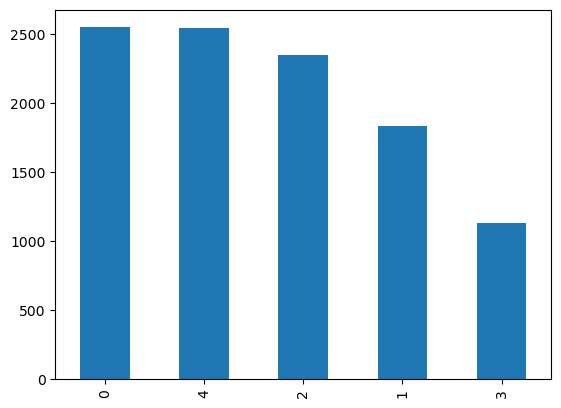

In [51]:
df['category'].value_counts().plot.bar()

## See sample image


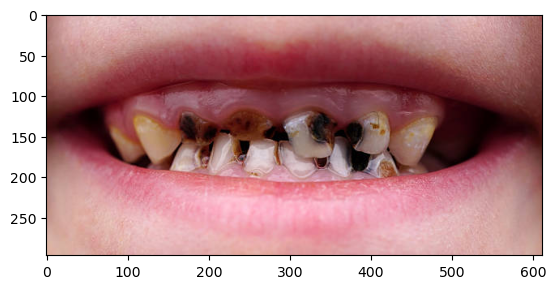

In [157]:

path =os.path.join(r"E:\\Data1\\traning")
file_list = os.listdir(path)
random_image = random.choice(file_list)
image_path = os.path.join(path, random_image)
image = Image.open(image_path)
#image.show()
plt.imshow(image)
plt.show()



## Build Model


In [113]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, Activation, BatchNormalization

model = Sequential()

model.add(Conv2D(64, (3, 3), activation='relu', input_shape=(IMAGE_WIDTH, IMAGE_HEIGHT, IMAGE_CHANNELS)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(3, 3)))
model.add(Dropout(0.25))

model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(3, 3)))
model.add(Dropout(0.25))

model.add(Conv2D(256, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(5, activation='softmax')) # 5 because we have cat and dog classes

model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

model.summary()

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_33 (Conv2D)          (None, 126, 126, 64)      1792      
                                                                 
 batch_normalization_44 (Bat  (None, 126, 126, 64)     256       
 chNormalization)                                                
                                                                 
 max_pooling2d_33 (MaxPoolin  (None, 42, 42, 64)       0         
 g2D)                                                            
                                                                 
 dropout_38 (Dropout)        (None, 42, 42, 64)        0         
                                                                 
 conv2d_34 (Conv2D)          (None, 40, 40, 128)       73856     
                                                                 
 batch_normalization_45 (Bat  (None, 40, 40, 128)    

## Callbacks

In [114]:
from keras.callbacks import EarlyStopping, ReduceLROnPlateau

### Early Stop

In [115]:
earlystop = EarlyStopping(patience=10)

### Learning Rate Reduction

In [116]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', 
                                            patience=2, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)

In [117]:
callbacks = [earlystop, learning_rate_reduction]

## Prepare data


In [118]:
df["category"] = df["category"].replace({0: 'Caries', 1: 'Discoloration', 2: 'Gingivitis', 3: 'hypodontia', 4: 'Mouth Ulcer'}) 

In [119]:
train_df, validate_df = train_test_split(df, test_size=0.20, random_state=42)
train_df = train_df.reset_index(drop=True)
validate_df = validate_df.reset_index(drop=True)

<AxesSubplot:>

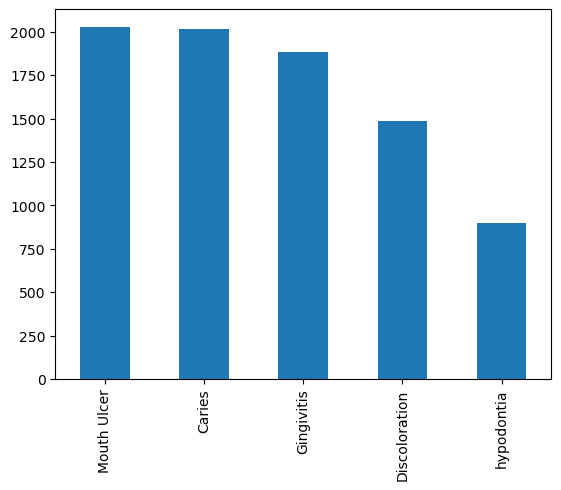

In [120]:
train_df['category'].value_counts().plot.bar()

<AxesSubplot:>

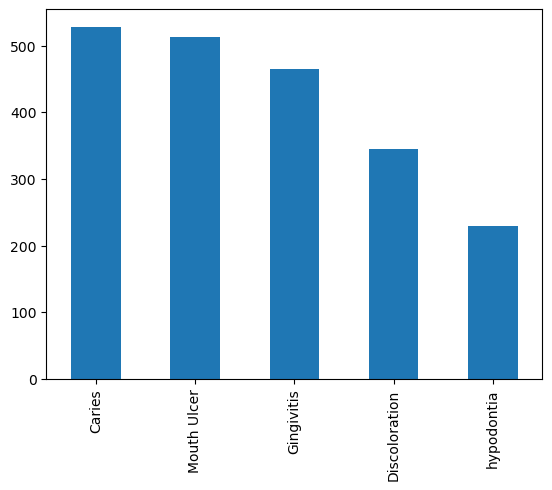

In [121]:
validate_df['category'].value_counts().plot.bar()

In [122]:
total_train = train_df.shape[0]
total_validate = validate_df.shape[0]
batch_size=15

## Traning Generator

In [123]:
train_datagen = ImageDataGenerator(
    rotation_range=5,
    rescale=1./255,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    width_shift_range=0.1,
    height_shift_range=0.1
)


train_generator = train_datagen.flow_from_dataframe(
    train_df, 
     "E:\\Data1\\traning", 
    x_col='filename',
    y_col='category',
    target_size=IMAGE_SIZE,
    class_mode='categorical',
    batch_size=batch_size
)

Found 8321 validated image filenames belonging to 5 classes.


## Validation Generator

In [124]:
validation_datagen = ImageDataGenerator(rescale=1./255)
validation_generator = validation_datagen.flow_from_dataframe(
    validate_df, 
    "E:\\Data1\\traning", 
    x_col='filename',
    y_col='category',
    target_size=IMAGE_SIZE,
    class_mode='categorical',
    batch_size=batch_size
)

Found 2081 validated image filenames belonging to 5 classes.


## See how our generator work

In [171]:
example_df = train_df.sample(n=1).reset_index(drop=True)
example_generator = train_datagen.flow_from_dataframe(
    example_df, 
    "E:\\Data1\\traning", 
    x_col='filename',
    y_col='category',
    target_size=IMAGE_SIZE,
    class_mode='categorical'
)

Found 1 validated image filenames belonging to 1 classes.


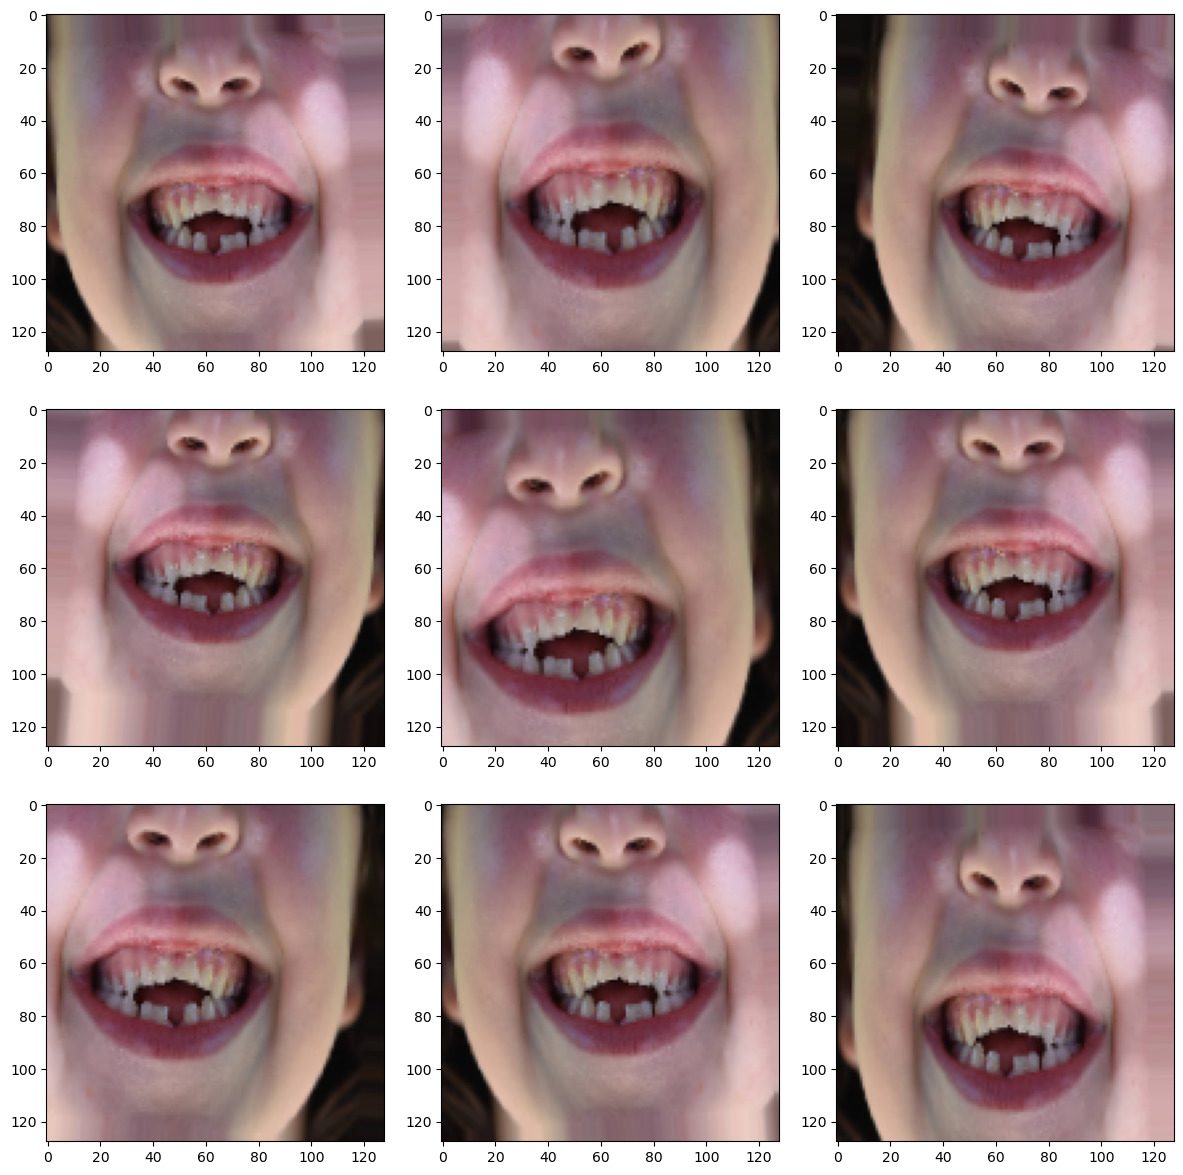

In [172]:
plt.figure(figsize=(12, 12))
for i in range(0, 9):
    plt.subplot(3, 3, i+1)
    for X_batch, Y_batch in example_generator:
        image = X_batch[0]
        plt.imshow(image)
        break
plt.tight_layout()
plt.show()

## Fit Model

In [138]:
epochs=3 if FAST_RUN else 30
history = model.fit_generator(
    train_generator, 
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=total_validate//batch_size,
    steps_per_epoch=total_train//batch_size,
    callbacks=callbacks
)

Epoch 1/30


C:\Users\hp\AppData\Local\Temp\ipykernel_12476\3838788663.py:2: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(


554/554 [==============================] - 169s 305ms/step - loss: 0.3486 - accuracy: 0.8744 - val_loss: 0.5193 - val_accuracy: 0.8048 - lr: 0.0010
Epoch 2/30
554/554 [==============================] - 170s 307ms/step - loss: 0.3542 - accuracy: 0.8789 - val_loss: 0.3027 - val_accuracy: 0.8966 - lr: 0.0010
Epoch 3/30
554/554 [==============================] - 169s 305ms/step - loss: 0.3264 - accuracy: 0.8863 - val_loss: 0.5688 - val_accuracy: 0.8072 - lr: 0.0010
Epoch 4/30
554/554 [==============================] - 169s 304ms/step - loss: 0.3531 - accuracy: 0.8758 - val_loss: 0.5060 - val_accuracy: 0.8517 - lr: 0.0010
Epoch 5/30
554/554 [==============================] - 173s 312ms/step - loss: 0.3339 - accuracy: 0.8801 - val_loss: 0.4237 - val_accuracy: 0.8285 - lr: 0.0010
Epoch 6/30
554/554 [==============================] - 182s 329ms/step - loss: 0.3220 - accuracy: 0.8912 - val_loss: 0.4413 - val_accuracy: 0.8271 - lr: 0.0010
Epoch 7/30
554/554 [==============================] - 175

## Save Model

In [139]:
model.save_weights("model.h5")

## Virtualize Training


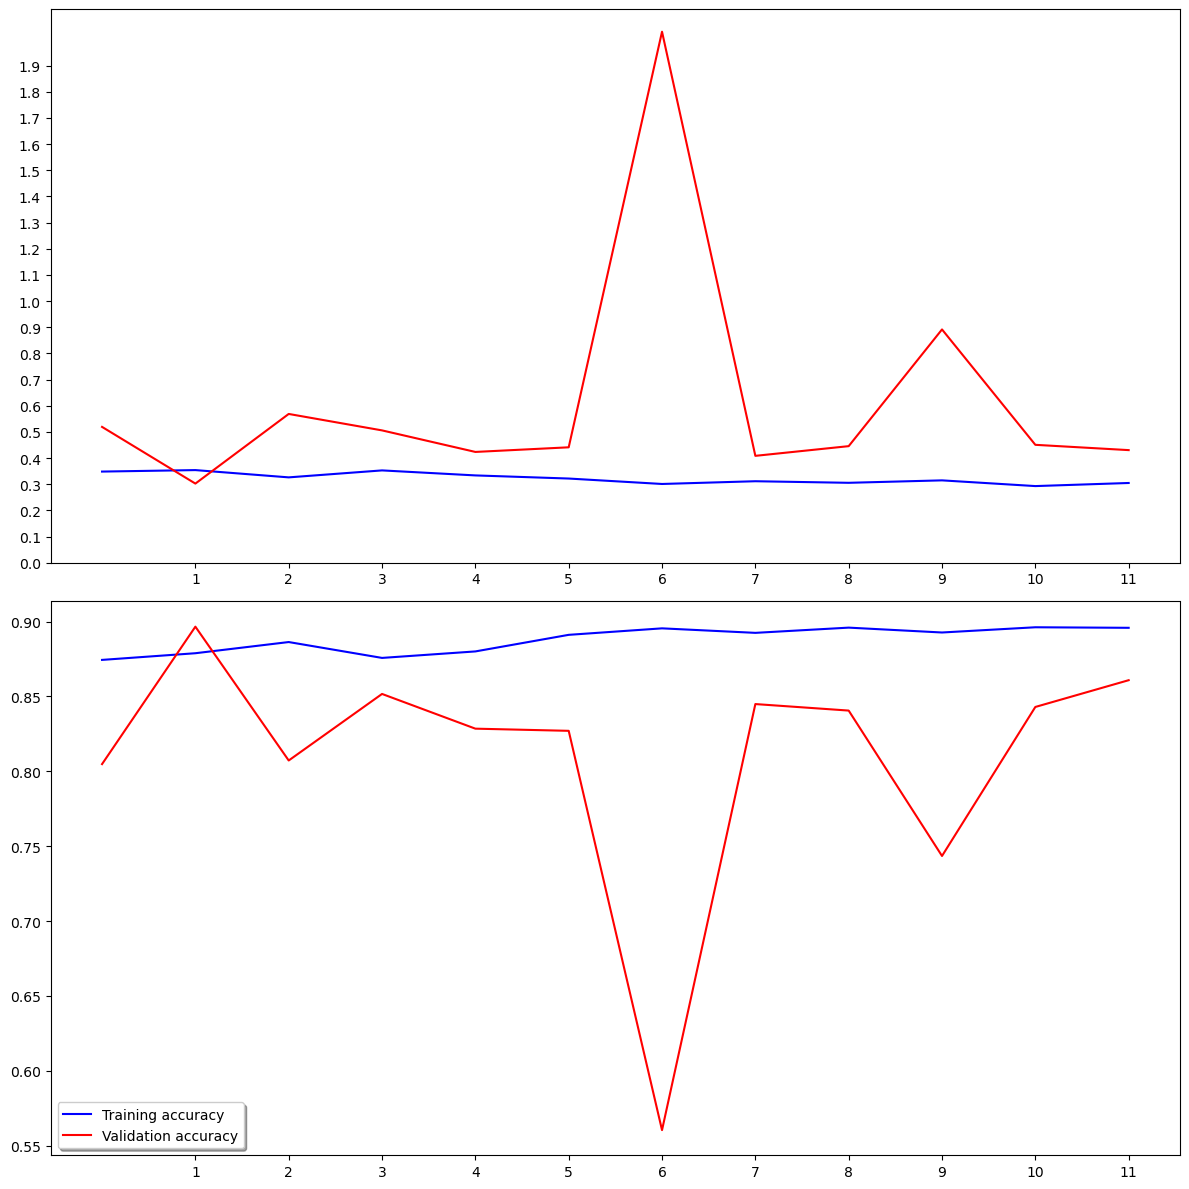

In [153]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 12))
ax1.plot(history.history['loss'], color='b', label="Training loss")
ax1.plot(history.history['val_loss'], color='r', label="validation loss")
ax1.set_xticks(np.arange(1,12, 1))
ax1.set_yticks(np.arange(0, 2, 0.1))

ax2.plot(history.history['accuracy'], color='b', label="Training accuracy")
ax2.plot(history.history['val_accuracy'], color='r',label="Validation accuracy")
ax2.set_xticks(np.arange(1,12, 1))

legend = plt.legend(loc='best', shadow=True)
plt.tight_layout()
plt.show()

# Prepare Testing Data

In [141]:
test_filenames = os.listdir(r"E:\\Data1\\vale")
test_df = pd.DataFrame({
    'filename': test_filenames
})
nb_samples = test_df.shape[0]

# Create Testing Generator

In [142]:
test_gen = ImageDataGenerator(rescale=1./255)
test_generator = test_gen.flow_from_dataframe(
    test_df, 
    r"E:\\Data1\\vale", 
    x_col='filename',
    y_col=None,
    class_mode=None,
    target_size=IMAGE_SIZE,
    batch_size=batch_size,
    shuffle=False
)

Found 810 validated image filenames.


# Predict

In [143]:
predict = model.predict_generator(test_generator, steps=np.ceil(nb_samples/batch_size))

C:\Users\hp\AppData\Local\Temp\ipykernel_12476\3090721588.py:1: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  predict = model.predict_generator(test_generator, steps=np.ceil(nb_samples/batch_size))


In [144]:
test_df['category'] = np.argmax(predict, axis=-1)

In [145]:
label_map = dict((v,k) for k,v in train_generator.class_indices.items())
test_df['category'] = test_df['category'].replace(label_map)

In [146]:
test_df["category"] = test_df["category"].replace({'Caries':0, 'Discoloration':1, 'Gingivitis':2,'hypodontia':3,'Mouth Ulcer':4}) 

# Virtaulize Result

<AxesSubplot:>

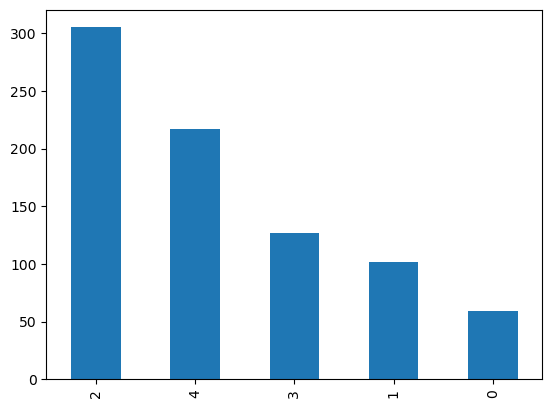

In [147]:
test_df['category'].value_counts().plot.bar()

# See predicted result with images

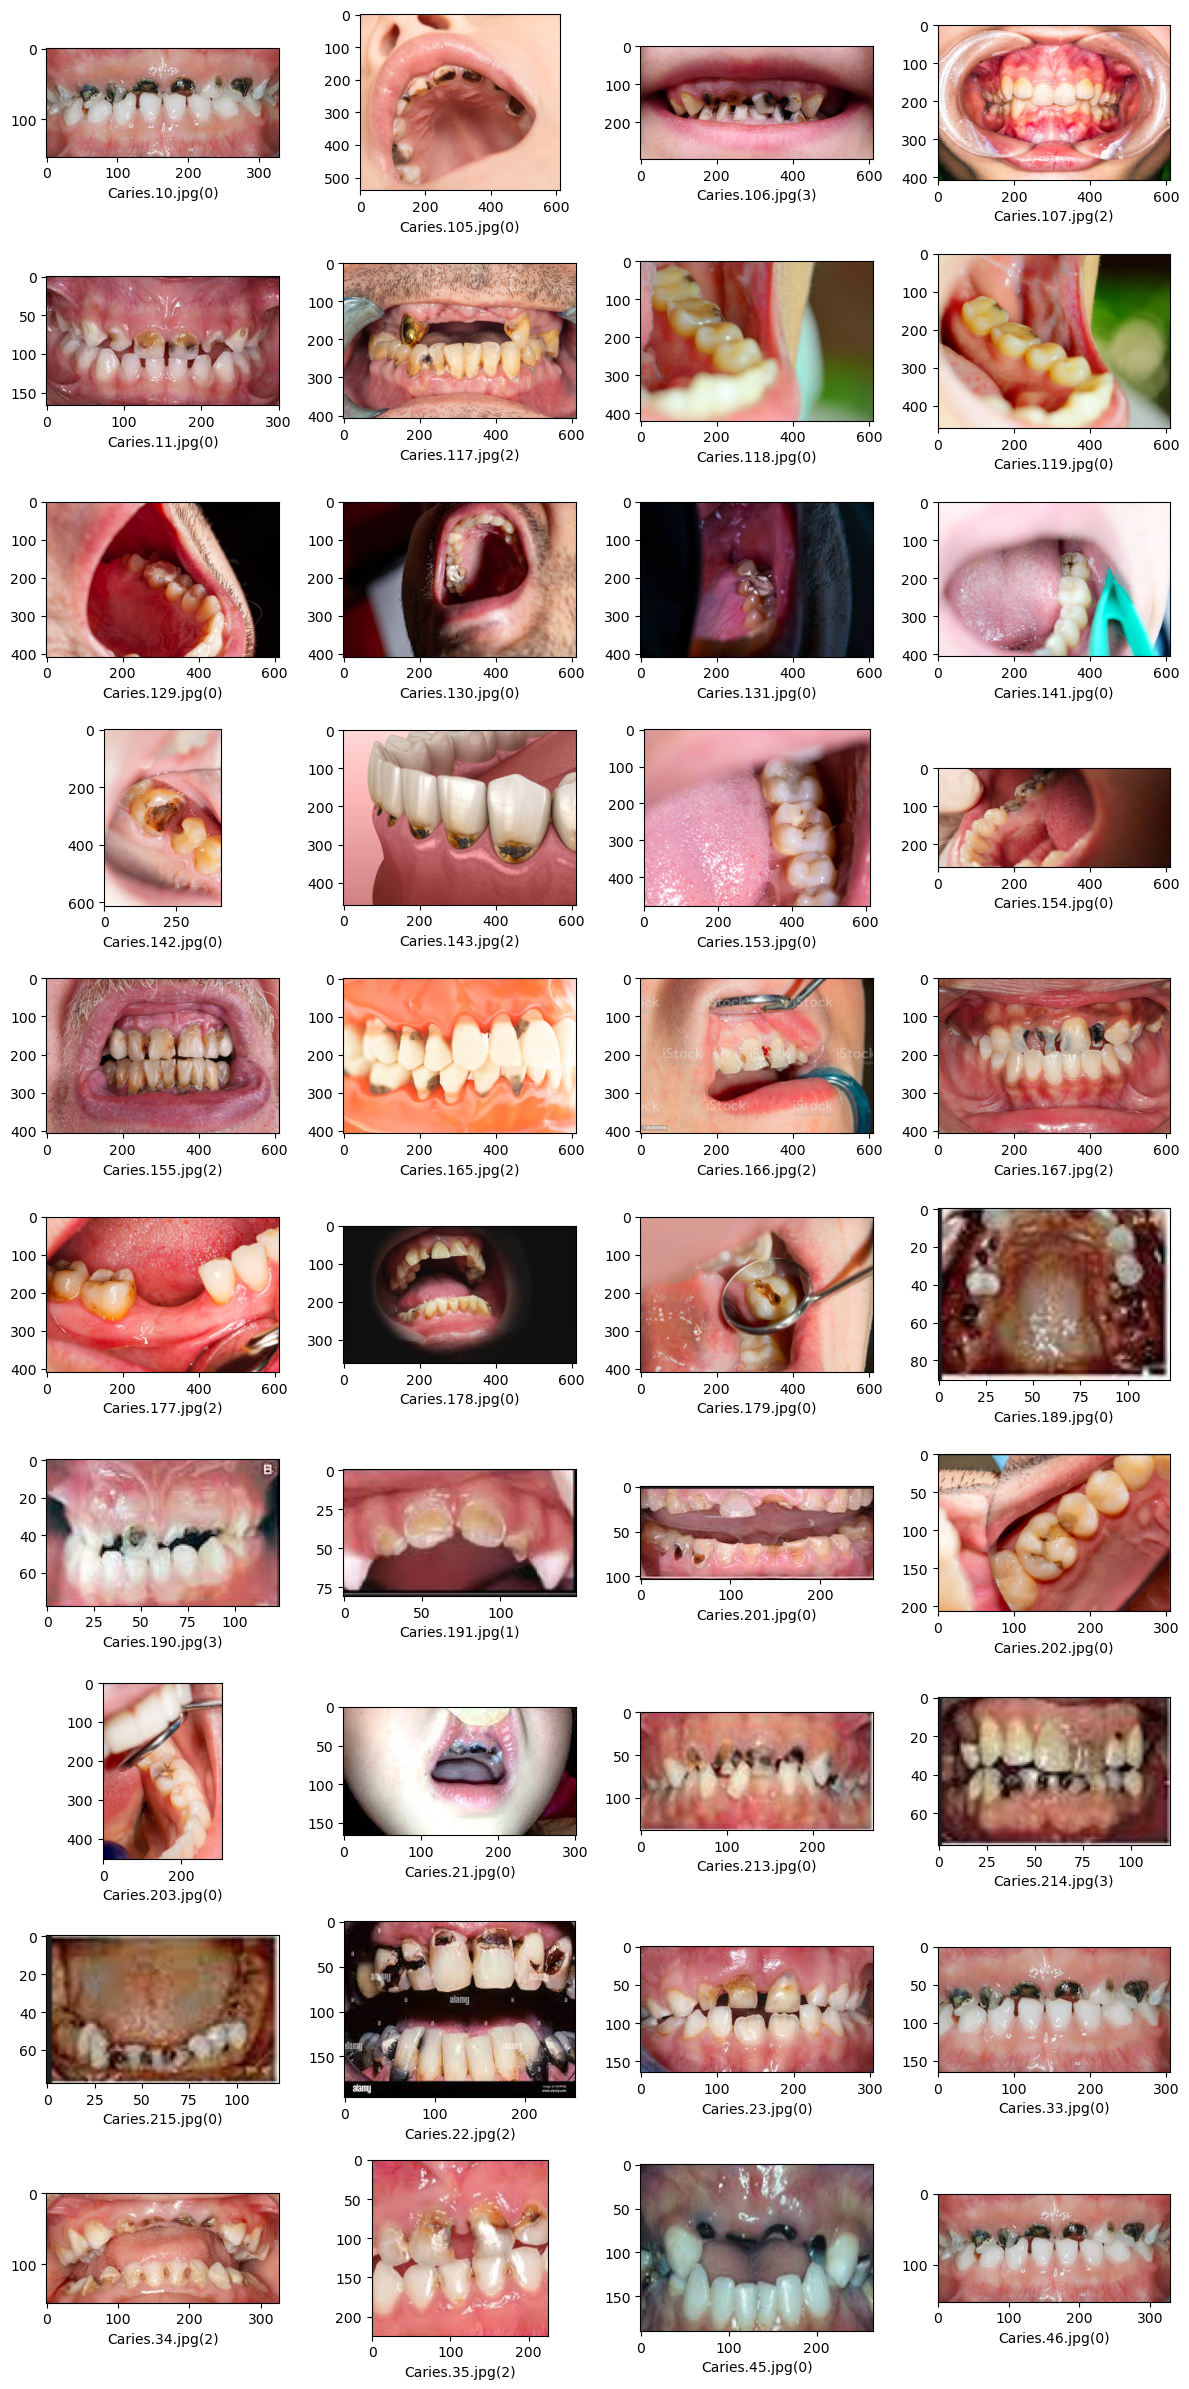

In [148]:
sample_test = test_df.head(40)
sample_test.head()
plt.figure(figsize=(12, 24))
for index, row in sample_test.iterrows():
    filename = row['filename']
    category = row['category']
    img = Image.open(r"E:\\Data1\\vale"+'\\'+filename)
    plt.subplot(10, 4, index+1)
    plt.imshow(img)
    plt.xlabel(filename + '(' + "{}".format(category) + ')' )
plt.tight_layout()
plt.show()

# Submission

In [149]:
submission_df = test_df.copy()
submission_df['id'] = submission_df['filename'].str.split('.').str[0]
submission_df['label'] = submission_df['category']
submission_df.drop(['filename', 'category'], axis=1, inplace=True)
submission_df.to_csv('submission.csv', index=False)